In [2]:
import os
import pandas as pd
import numpy as np
from numpy import where
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, auc, roc_auc_score, roc_curve, classification_report, cohen_kappa_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

In [3]:
X_res = pd.read_csv(
    'Data/Processed_Datasets/Train_test_tables/df_x_res.csv', index_col=0)
y_res = pd.read_csv(
    'Data/Processed_Datasets/Train_test_tables/df_y_res.csv', index_col=0)
X_test_normalized = pd.read_csv(
    'Data/Processed_Datasets/Train_test_tables/df_x_test_normalized.csv', index_col=0)
y_test = pd.read_csv(
    'Data/Processed_Datasets/Train_test_tables/df_y_test.csv', index_col=0)

# Model 1: Extreme gradient boosted tree (LightGBM)

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, make_scorer
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
import multiprocessing
import joblib

In [5]:
X_train = X_res.reset_index(drop=True)
y_train = y_res.reset_index(drop=True)
print("Resampled Training set shape: ", X_train.shape, y_train.shape)

Resampled Training set shape:  (114270, 41) (114270, 1)


In [6]:
# combine X_train and y_train into a single dataframe
df_train = pd.concat([X_train, y_train], axis=1)

# shuffle the dataframe using the shuffle function
df_train = shuffle(df_train, random_state=42)

# split the shuffled dataframe back into X_train and y_train
X_train = df_train.drop('FIRE_RISK_1_MONTH_FORWARD_SHIFT', axis=1)
y_train = df_train['FIRE_RISK_1_MONTH_FORWARD_SHIFT']

In [7]:
# Get the number of CPU cores available
n_cpus = multiprocessing.cpu_count()
print("Number of available CPU cores: ", n_cpus)

Number of available CPU cores:  12


In [8]:
import xgboost as xgb
import multiprocessing
import joblib
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np


In [16]:
!pip uninstall lightgbm scikit-optimize
!pip install lightgbm scikit-optimize

^C


In [12]:
!pip install --upgrade numpy

Requirement already up-to-date: numpy in c:\users\ajimp\appdata\roaming\python\python38\site-packages (1.24.2)


In [17]:
import lightgbm as lgb
import multiprocessing
import joblib
from sklearn.metrics import f1_score, make_scorer
from skopt import BayesSearchCV
import numpy as np

# Split the data into a training set and a validation set
X_train_g, X_val_g, y_train_g, y_val_g = train_test_split(
    X_train, y_train, test_size=0.1, random_state=12)

# Define the LightGBM classifier with early stopping
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=5, n_jobs=-1,
                               early_stopping_rounds=10)

# Define the parameter space for Bayesian optimization
param_space = {
    'max_depth': (20, 200),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'n_estimators': (500, 900),
    'min_child_samples': (5, 50),
    'subsample': (0.5, 0.9, 'uniform'),
    'colsample_bytree': (0.5, 0.9, 'uniform'),
    'reg_alpha': (0.1, 10.0, 'log-uniform'),
    'reg_lambda': (0.1, 10.0, 'log-uniform')
}

# Define scoring metric as macro-averaged F1-score
scorer = make_scorer(f1_score, average='macro')

# Create a BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=lgb_model, search_spaces=param_space, scoring=scorer, n_jobs=n_cpus,
    verbose=10, n_iter=50, cv=3, random_state=42)

# Fit the BayesSearchCV object
with joblib.parallel_backend('multiprocessing'):
    bayes_search.fit(X_train_g, y_train_g, eval_set=[(X_val_g, y_val_g)])

# Print the best hyperparameters and their score
print("Best hyperparameters: ", bayes_search.best_params_)
print("Best score: ", bayes_search.best_score_)


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [8]:
# Split the data into a training set and a validation set
X_train_g, X_val_g, y_train_g, y_val_g = train_test_split(
    X_train, y_train, test_size=0.1, random_state=12)

# Initialize the XGBoost regressor with the callbacks parameter set in the constructor
callbacks = [xgb.callback.EarlyStopping(rounds=10, save_best=True)]
xgb_model = xgb.XGBRegressor(
    num_class=5, objective='multi:softprob', callbacks=callbacks)

# Get the number of CPU cores available
n_cpus = multiprocessing.cpu_count()
print("Number of available CPU cores: ", n_cpus)

# Define the parameter grid for randomized search
param_distributions = {
    'max_depth': [20, 40, 80, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [500, 700, 900],
    'gamma': [0.1, 0.5, 1.0],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'reg_alpha': [0.1, 1.0, 10.0],
    'reg_lambda': [0.1, 1.0, 10.0]
}

# Define scoring metric as macro-averaged F1-score
scorer = make_scorer(f1_score, average='macro')

# Create a randomized search object with early stopping
random_search = RandomizedSearchCV(
    estimator=xgb_model, param_distributions=param_distributions, scoring=scorer, n_jobs=n_cpus,
    verbose=4, return_train_score=True, n_iter=100, cv=3, random_state=42)

# Fit the randomized search object with early stopping
with joblib.parallel_backend('multiprocessing'):
    random_search.fit(X_train_g, y_train_g, eval_set=[(X_val_g, y_val_g)])

# Print the best hyperparameters and their score
print("Best hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)


NameError: name 'X_val' is not defined

In [28]:
# Define the cross-validation method
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Initialize variables to store metrics
bal_acc_sum = 0
f1_samples_sum = 0
roc_auc_sum = 0

# Loop over each fold in the cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

    # Initialize the XGBoost classifier with best hyperparameters from grid search
    xgb_model = xgb.XGBClassifier(**grid_search.best_params_, num_class=5,
                                  objective='multi:softprob', eval_metric=['mlogloss'], tree_method='gpu_hist', gpu_id=0)

    # Fit the classifier to the training data
    xgb_model.fit(X_train_cv, y_train_cv)

    # Make predictions on the validation data
    y_pred = xgb_model.predict(X_val)
    y_pred_proba = xgb_model.predict_proba(X_val)

    # Compute evaluation metrics
    bal_acc = balanced_accuracy_score(y_val, y_pred)
    f1_sample = f1_score(y_val, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_val, y_pred_proba, multi_class='ovr')

    # Print evaluation metrics for current fold
    print(f"FOLD {fold} -> Balanced Accuracy: {bal_acc:.3f}, F1-score: {f1_sample:.3f}, ROC-AUC score: {roc_auc:.3f}")

    # Add metrics to running totals
    bal_acc_sum += bal_acc
    f1_samples_sum += f1_sample
    roc_auc_sum += roc_auc

# Compute average metrics across all folds
xgb_avg_bal_acc = bal_acc_sum / kf.get_n_splits()
xgb_avg_f1_samples = f1_samples_sum / kf.get_n_splits()
xgb_avg_roc_auc = roc_auc_sum / kf.get_n_splits()

# Print average metrics
print(
    f"Average for all folds -> Balanced Accuracy: {xgb_avg_bal_acc:.3f}, F1-score: {xgb_avg_f1_samples:.3f}, ROC-AUC score: {xgb_avg_roc_auc:.3f}")


FOLD 0 -> Balanced Accuracy: 0.918, F1-score: 0.918, ROC-AUC score: 0.991
FOLD 1 -> Balanced Accuracy: 0.919, F1-score: 0.919, ROC-AUC score: 0.992
FOLD 2 -> Balanced Accuracy: 0.919, F1-score: 0.918, ROC-AUC score: 0.992
FOLD 3 -> Balanced Accuracy: 0.919, F1-score: 0.919, ROC-AUC score: 0.991
FOLD 4 -> Balanced Accuracy: 0.918, F1-score: 0.918, ROC-AUC score: 0.991
Average for all folds -> Balanced Accuracy: 0.918, F1-score: 0.918, ROC-AUC score: 0.991


In [29]:
X_test = X_test_normalized.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
print("Test set shape: ", X_test.shape, y_test.shape)

Test set shape:  (17136, 41) (17136, 1)


In [30]:
# make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)

# evaluate the performance on the test set
test_bal_acc = balanced_accuracy_score(y_test, y_pred)
test_f1_sample = f1_score(y_test, y_pred, average='weighted')
test_roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"TEST RESULTS -> Balanced Accuracy: {test_bal_acc:.3f}, F1-score: {test_f1_sample:.3f}, ROC-AUC score: {test_roc_auc:.3f}")

TEST RESULTS -> Balanced Accuracy: 0.651, F1-score: 0.701, ROC-AUC score: 0.922


In [31]:
XGBoost_results = {
    "Parameters": xgb_model.get_params,
    "Test balanced accuracy score": test_bal_acc,
    "Test sampled F1-score": test_f1_sample,
    "Test ROC-AUC (One vs Rest) score": test_roc_auc
}
print(XGBoost_results)

{'Parameters': <bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=0.5, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=20, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob', ...)>, 'Test balanced accuracy score': 0.6507802538580463, 'Test sampled F1-score': 0.7011965846276702, 'Test ROC-AUC (One vs Rest) score': 0.9215208376607172}


## Model Evaluation & Performance

## Error Analysis

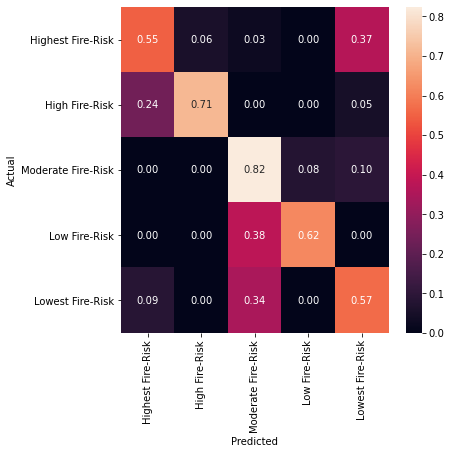

In [49]:
import seaborn as sns

# Confusion Matrix
target_names = ['Highest Fire-Risk', 'High Fire-Risk',
                'Moderate Fire-Risk', 'Low Fire-Risk', 'Lowest Fire-Risk']
XGB_confusion_matrix = confusion_matrix(y_test, y_pred)
XGB_confusion_matrix_n = XGB_confusion_matrix.astype('float') / XGB_confusion_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(XGB_confusion_matrix_n, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

XGB_cm_df = pd.DataFrame(XGB_confusion_matrix_n, index=['True 1', 'True 2', 'True 3', 'True 4', 'True 5'],
                             columns=target_names)

# Display the DataFrame
XGB_cm_df

# File Output
XGB_cm_file_name = 'XGB_confusion_matrix.xlsx'
XGB_cm_file_path = 'Data/Data_visualization_tables/' + XGB_cm_file_name
if os.path.exists(XGB_cm_file_name):
    os.remove(XGB_cm_file_name)
    XGB_cm_df.to_excel(XGB_cm_file_path, index=True)
else:
    XGB_cm_df.to_excel(XGB_cm_file_path, index=True)

In [50]:
# Classification report
target_names = ['Highest Fire-Risk', 'High Fire-Risk',
                'Moderate Fire-Risk', 'Low Fire-Risk', 'Lowest Fire-Risk']
XGB_report_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

# Convert the dictionary to a DataFrame
XGB_report_df = pd.DataFrame(XGB_report_dict).transpose()

# Display the DataFrame
XGB_report_df

# File Output
XGB_r_file_name = 'XGB_class_report_matrix.xlsx'
XGB_r_file_path = 'Data/Data_visualization_tables/' + XGB_r_file_name
if os.path.exists(XGB_r_file_name):
    os.remove(XGB_r_file_name)
    XGB_report_df.to_csv(XGB_r_file_path, index=True)
else:
    XGB_report_df.to_csv(XGB_r_file_path, index=True)

In [52]:
xg_probs = xgb_model.predict(d_test)

#Macro averaging: Taking fpr, tpr of each classification (one vs rest) and taking the average
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

macro_roc_auc_ovr = roc_auc_score(
    y_test,
    xg_probs,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

NameError: name 'd_test' is not defined

In [243]:
y_test_arr = y_test.to_numpy()
n_classes = len(y_test['FIRE_RISK_1_MONTH_FORWARD_SHIFT'].unique())
classes = y_test['FIRE_RISK_1_MONTH_FORWARD_SHIFT'].unique()

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_arr, xg_probs[:,i],pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.93


In [244]:
d = {'FPR':fpr_grid,'TPR':mean_tpr}
XGB_roc_auc = pd.DataFrame(data=d)

XGB_roc_auc_file_name = 'XGB_roc_auc.xlsx'
XGB_cm_file_path = 'Data/Data_visualization_tables/' + XGB_roc_auc_file_name
if os.path.exists(XGB_roc_auc_file_name):
    os.remove(XGB_roc_auc_file_name)
    XGB_roc_auc.to_csv(XGB_cm_file_path, index=True)
else:
    XGB_roc_auc.to_csv(XGB_cm_file_path,index=True)

OSError: Cannot save file into a non-existent directory: 'Data/Data_visualization_tables'

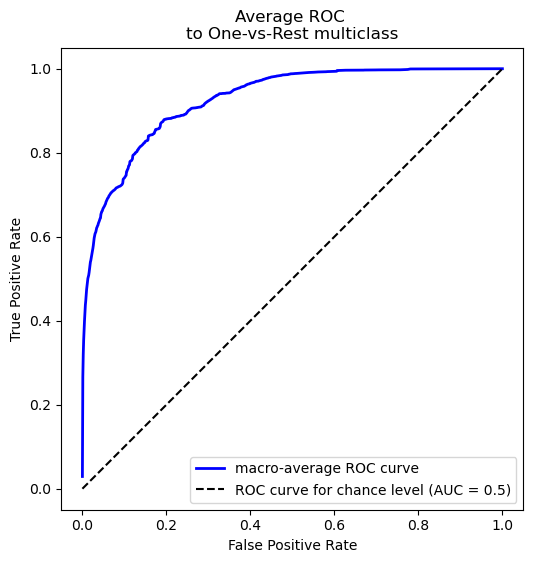

In [245]:
# Plotting ROC curve
fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve",
    color="blue",
    linewidth=2,
)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC \nto One-vs-Rest multiclass")
plt.legend()
plt.show()

In [246]:
#feature importance
fi = XGB_model.feature_importances_
sorted_idx = np.argsort(fi)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, fi[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

AttributeError: 'Booster' object has no attribute 'feature_importances_'

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

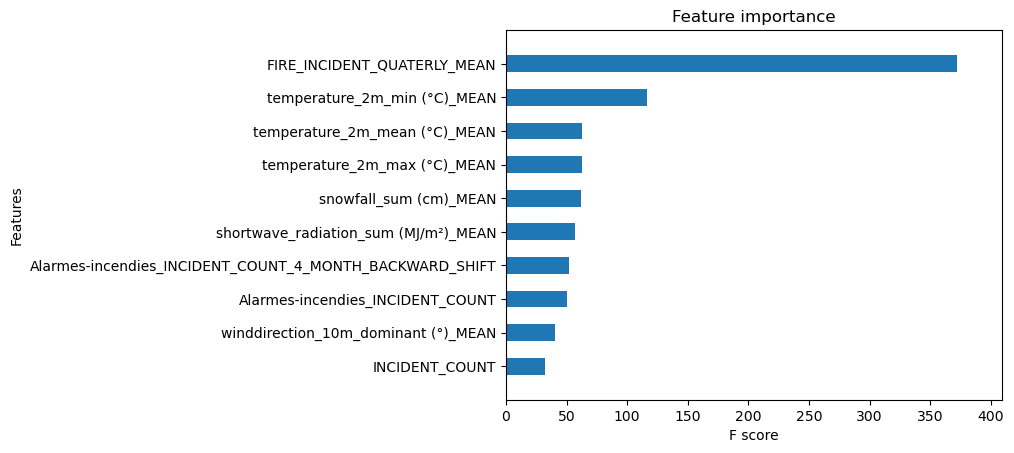

In [273]:
xgb.plot_importance(XGB_model,max_num_features=10, height=0.5, grid=False, show_values=False)

In [270]:
value = np.array(list(XGB_model.get_score(importance_type='weight').items()))

array([['CRIME_COUNT', '3.0'],
       ['Introduction_CRIME_COUNT', '21.0'],
       ['Méfait_CRIME_COUNT', '26.0'],
       ['Vol dans / sur véhicule à moteur_CRIME_COUNT', '8.0'],
       ['Vol de véhicule à moteur_CRIME_COUNT', '18.0'],
       ['Vols qualifiés_CRIME_COUNT', '7.0'],
       ['INCIDENT_COUNT', '32.0'],
       ['1-REPOND_INCIDENT_COUNT', '6.0'],
       ['AUTREFEU_INCIDENT_COUNT', '15.0'],
       ['Alarmes-incendies_INCIDENT_COUNT', '50.0'],
       ['FAU-ALER_INCIDENT_COUNT', '1.0'],
       ['INCENDIE_INCIDENT_COUNT', '5.0'],
       ['SANS FEU_INCIDENT_COUNT', '15.0'],
       ['UNIQUE_FIRE_STATION_COUNT', '9.0'],
       ['UNIQUE_DIVISION_COUNT', '7.0'],
       ['UNITS_DEPLOYED_SUM', '26.0'],
       ['UNITS_DEPLOYED_MEAN', '16.0'],
       ['temperature_2m_max (°C)_MEAN', '63.0'],
       ['temperature_2m_min (°C)_MEAN', '116.0'],
       ['temperature_2m_mean (°C)_MEAN', '63.0'],
       ['shortwave_radiation_sum (MJ/m²)_MEAN', '57.0'],
       ['precipitation_sum (mm)_MEAN', '11

In [29]:
d_fi = {"features": np.array(X_train.columns)[sorted_idx], "feature_importance":fi[sorted_idx]}
XGB_feature_importance = pd.DataFrame(data=d_fi)

XGB_fi_file_name = 'XGB_feature_importance.xlsx'
XGB_cm_file_path = 'Data/Data_visualization_tables/' + XGB_fi_file_name
if os.path.exists(XGB_fi_file_name):
    os.remove(XGB_fi_file_name)
    XGB_feature_importance.to_csv(XGB_cm_file_path, index=True)
else:
    XGB_feature_importance.to_csv(XGB_cm_file_path,index=True)